In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch_geometric
!pip install pymatreader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00


# Preparing Dataset

## Making Dataset from .mat file to .csv

In [ ]:
import pandas as pd
import numpy as np
from pymatreader import read_mat
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import os

#data_path = '/home/iqh4001/Iqram_WCM/MADE Lab/Kinect Project/gait-analysis-main_VT/AI_Frailty-MATLAB/AI_Frailty-MATLAB'


data_path = "/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Raw"
saving_path="/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample"





def KINZ_DATA_np(k):

  details = os.path.basename(k)

  p_id= details.split("_")[0].split("-")[-2]+"-"+ details.split("_")[0].split("-")[-1]
  traial = details.split("_")[1]
  walking_speed = details.split("_")[2]

  kinzData = read_mat(k)

  kinz_arr = np.empty([0,100])


  for i in range(len(kinzData["joint_positions"])):
      timeStamps = np.array(kinzData["t_uniform"][i])
      kinz_x = kinzData["joint_positions"][i][0]
      kinz_y = kinzData["joint_positions"][i][1]
      kinz_z = kinzData["joint_positions"][i][2]

      d = np.concatenate((p_id,traial,walking_speed,timeStamps,kinz_x,kinz_y,kinz_z), axis=None)

      kinz_arr = np.append(kinz_arr, [d], axis=0)

  return kinz_arr











final = np.empty([0,100])

for i in tqdm(sorted(glob(data_path+"/*"))):
  for k in sorted(glob(i+"/TS*.mat")):
    print("Processing: ", os.path.basename(k))
    temp_single = KINZ_DATA_np(k)
    #time_elements = temp_single[:, 3]

    #time_elements = time_elements.astype(float)
    #replacement_values = kinz_time(time_elements)[0]

    #temp_single[:, 3] = replacement_values
    final = np.append(final, temp_single, axis=0)


joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]


all_columns = ['patientID','trial_num','walking_speed','timeStamps']


for joint in joints:
  x = f'{joint}_X'
  all_columns.append(x)

for joint in joints:
  y = f'{joint}_Y'
  all_columns.append(y)

for joint in joints:
  z = f'{joint}_Z'
  all_columns.append(z)




final_df = pd.DataFrame(final, columns=all_columns)

columns_to_convert = final_df.columns.difference(['patientID','trial_num','walking_speed'])
final_df[columns_to_convert] = final_df[columns_to_convert].astype(float)




final_df.to_csv(saving_path+'/KINZ_JOINT.csv', index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

Processing:  TS-Cln-001-LO_Trial1_Regular_20220307_111113.mat
Processing:  TS-Cln-001-LO_Trial2_Regular_20220307_111139.mat
Processing:  TS-Cln-001-LO_Trial3_Fast_20220307_111208.mat
Processing:  TS-Cln-001-LO_Trial4_Fast_20220307_111234.mat
Processing:  TS-Cln-001-LO_Trial5_Fast_20220307_111347.mat
Processing:  TS-Cln-001-LO_Trial6_Fast_20220307_111427.mat
Processing:  TS-Cln-001-LO_Trial6_Fast_20220307_111722.mat
Processing:  TS-Cln-002-RJ_Trial2_Regular_20220311_100440.mat
Processing:  TS-Cln-002-RJ_Trial3_Fast_20220311_100509.mat
Processing:  TS-Cln-002-RJ_Trial4_Fast_20220311_100541.mat
Processing:  TS-Cln-002-RJ_Trial4_Fast_20220311_100659.mat
Processing:  TS-Cln-RM-003_Trial1_Regular_20220315_060038.mat
Processing:  TS-Cln-RM-003_Trial2_Regular_20220315_060059.mat
Processing:  TS-Cln-RM-003_Trial3_Fast_20220315_060209.mat
Processing:  TS-Cln-RM-003_Trial4_Fast_20220315_060226.mat
Processing:  TS-Cln-RM-003_Trial4_Fast_20220315_060742.mat
Processing:  TS-Cln-004-MF_Trial3_Regular

## Marging Target column from ClinicalData

In [ ]:
import pandas as pd
import numpy as np

kinz_df= pd.read_csv("/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/temp/KINZ_JOINT.csv")

clinic_df = pd.read_csv("/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/ClinicalData80.csv")

In [ ]:
import numpy as np
from tqdm import tqdm


kinz_np = kinz_df.values # converting to np array

new_kinz = []
not_found_sub = []

class_col = "TotalFFIScore"



for i in tqdm(kinz_np):

  # some RecordId name formate is not matching with the main data file....So we have to re formate the name
  sep = i[0].split("-")
  if sep[0].isdigit():
    sub = i[0]
  else:
    sub  = sep[-1]+"-"+sep[0]

  #quearing the TotalFFIScore
  total_ffi_score = clinic_df[clinic_df["RecordID"]==sub][class_col]

  # Check if total_ffi_score is not empty
  if not total_ffi_score.empty:
    new_row = np.append(i, total_ffi_score.iloc[0])
  else:
    not_found_sub.append(i[0])
    new_row = np.append(i, 'nan')  # Append 'nan' for missing values
    #print("Loop broke!!!")

  new_kinz.append(new_row)




kinz_np = np.array(new_kinz)




new_target_name = "frailty_class"

df = pd.DataFrame(kinz_np, columns=kinz_df.columns.to_list()+[new_target_name])







100%|██████████| 82942/82942 [00:42<00:00, 1964.02it/s]


<font color='red'>Run this cell if you want replace some value. Otherwise do not run it. This is a defalut code for frailty_score

In [ ]:
replace_values = {0.0:0 ,1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1}

### Dataframe with Target Column

In [ ]:

df[new_target_name] = df[new_target_name].replace(replace_values)

### Class_Subjectwise_Dividation

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Separate the data by frailty_class
class_0 = df[df[new_target_name] == 1.0]
class_1 = df[df[new_target_name] == 0.0]

# Group by 'patientID' and sample patients
class_0_patient_ids = class_0['patientID'].unique()
class_1_patient_ids = class_1['patientID'].unique()

# Determine the number of patients to sample
num_patients = min(len(class_0_patient_ids), len(class_1_patient_ids))

# Sample patients
sampled_class_0_patient_ids = class_0_patient_ids[:num_patients]
sampled_class_1_patient_ids = class_1_patient_ids[:num_patients]

# Filter the data to only include the sampled patients
sampled_class_0 = class_0[class_0['patientID'].isin(sampled_class_0_patient_ids)]
sampled_class_1 = class_1[class_1['patientID'].isin(sampled_class_1_patient_ids)]

# Combine the balanced classes
balanced_df = pd.concat([sampled_class_0, sampled_class_1])

# Shuffle the DataFrame to mix the classes
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Number of patients in class 0: {len(sampled_class_0_patient_ids)}")
print(f"Number of patients in class 1: {len(sampled_class_1_patient_ids)}")


Number of patients in class 0: 21
Number of patients in class 1: 21


In [ ]:
balanced_df

,patientID,trial_num,walking_speed,timeStamps,PELVIS_X,SPINE_NAVAL_X,SPINE_CHEST_X,NECK_X,CLAVICLE_LEFT_X,SHOULDER_LEFT_X,...,KNEE_RIGHT_Z,ANKLE_RIGHT_Z,FOOT_RIGHT_Z,HEAD_Z,NOSE_Z,EYE_LEFT_Z,EAR_LEFT_Z,EYE_RIGHT_Z,EAR_RIGHT_Z,frailty_class
0,007-LI,Trial5,Fast,1.373069,241.685633,227.145064,217.469318,214.433264,247.747348,383.111158,...,5345.382872,5481.421339,5447.827404,5172.873042,5020.606278,5033.971174,5125.856712,5042.283765,5160.87621,0
1,011-CB,Trial2,Regular,3.12306,294.184465,290.498545,286.727493,282.647642,314.236408,444.722798,...,1631.354903,1804.654404,1742.0362,1460.93647,1315.285825,1346.199519,1454.356723,1338.613409,1442.299163,0
2,014-WF,Trial4,Fast,5.712975,767.295415,750.570816,738.084216,735.257337,768.596275,905.279041,...,1884.325083,2053.057735,1944.71228,1585.984318,1463.993319,1481.233774,1587.707036,1455.575605,1509.100568,1
3,020-MM,Trial3,Fast,2.279243,196.116219,203.057347,207.410151,194.632179,158.896781,5.682481,...,4215.248807,3955.954492,4007.365285,3881.976519,3742.056033,3728.038709,3795.587569,3745.136258,3849.673044,0
4,005-GP,Trial5,Fast,3.067225,904.887142,881.980325,859.205179,815.846898,789.976034,660.949808,...,6722.386929,6540.402968,6514.160445,6642.926771,6802.142104,6780.235001,6668.0734,6785.886951,6676.874253,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44938,019-ER,Trial4,Fast,0.124171,180.605405,161.942089,159.63083,162.408906,189.435819,292.06764,...,7847.532595,7942.177426,7896.238408,7772.989008,7593.426217,7614.892506,7731.168389,7618.192738,7752.682832,1
44939,071-EK,Trial4,Fast,1.107466,91.971921,95.1873,95.504196,87.74394,125.960472,269.422487,...,5517.486546,5627.402745,5510.318274,5317.96818,5143.932247,5170.913355,5284.760533,5174.834091,5310.411135,0
44940,041-JL,Trial2,Regular,0.103072,11.638335,12.303281,13.097746,14.646888,-16.653292,-141.964931,...,1316.716253,1382.304309,1531.910892,952.622022,883.045735,865.594791,865.312194,906.244116,996.786045,0
44941,001-LO,Trial4,Fast,2.259439,126.516493,129.341927,130.590103,131.929393,163.098274,296.936448,...,3192.500287,3463.914924,3365.914665,3240.275155,3094.973612,3117.82729,3229.007693,3104.338429,3193.930373,1


In [ ]:
final_data_saving_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'


balanced_df.to_csv(final_data_saving_path, index=False)

# Model And XAI

In [ ]:

import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import torch
import plotly.graph_objs as go
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm



In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np


import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import torch
import plotly.graph_objs as go
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Dataset, Data
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np





# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'),('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}

edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()


# Custom Dataset Class
class SkeletonDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file
        self.num_nodes = len(joints)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract node features and include timestamp
        node_features = []
        for joint in joints:
            x = row[f'{joint}_X']
            y = row[f'{joint}_Y']
            z = row[f'{joint}_Z']
            timestamp = row['timeStamps']  # Include timestamp as a feature
            node_features.append([x, y, z, timestamp])

        x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

        # Label
        y = torch.tensor(row['frailty_class'], dtype=torch.float)

        # Create data object
        data = Data(x=x, edge_index=edge_index, y=y)

        return data




class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(HybridSTGCN, self).__init__()

        # Spatial Graph Convolution Layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Temporal Convolution Layers
        self.temporal_conv1 = nn.Conv1d(in_channels=hidden_channels,
                                        out_channels=hidden_channels,
                                        kernel_size=3, padding=1)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)  # Use batch if available, else None

        # Spatial GCN Layers
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))  # x: [num_nodes*batch_size, hidden_channels]

        # Reshape for Temporal Conv
        if batch is not None:
            batch_size = batch.max().item() + 1
            num_nodes = x.size(0) // batch_size
        else:
            batch_size = 1
            num_nodes = x.size(0)

        x = x.view(batch_size, num_nodes, -1)  # [batch_size, num_nodes, hidden_channels]
        x = x.permute(0, 2, 1)  # [batch_size, hidden_channels, num_nodes]

        # Temporal Conv Layer
        x = F.relu(self.temporal_conv1(x))  # [batch_size, hidden_channels, num_nodes]

        # LSTM for capturing temporal patterns
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes, hidden_channels]
        x, _ = self.lstm(x)  # [batch_size, num_nodes, hidden_channels]

        # Pooling over nodes
        x = x.mean(dim=1)  # [batch_size, hidden_channels]

        # Fully Connected Layer
        x = self.fc(x)  # [batch_size, num_classes]
        x = torch.sigmoid(x)  # For binary classification

        return x.squeeze()  # [batch_size]






data_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'



dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]



# Load dataset
dataset = SkeletonDataset(csv_file=dataframe[dataframe['walking_speed'] == "Fast"])






# Split into training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])



# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



# Training Function
def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # [batch_size]
        y = data.y.to(device).float()  # [batch_size]

        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        preds = (out >= 0.5).float()
        correct += (preds == y).sum().item()
        total += data.num_graphs

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / total
    print(f'Epoch {epoch}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy



# Evaluation Function
def evaluate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)  # Ensure the output is of shape [batch_size]
            y = data.y.to(device).float().view(-1)  # Ensure target is of shape [batch_size]
            preds = (out >= 0.5).float()

            total_loss += criterion(out, y.float()).item() * data.num_graphs
            correct += (preds == y).sum().item()
            total += data.num_graphs
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_labels










class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights and self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        return False




# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=3, min_delta=0.01, restore_best_weights=True)

# Training Loop with Early Stopping
num_epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    # Train the model and get training loss and accuracy
    train_loss, train_acc = train(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model on the test set and get test loss and accuracy
    test_loss, test_acc, all_preds, all_labels = evaluate(test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Check for early stopping
    if early_stopping(test_loss, model):
        print("Early stopping triggered.")
        break

# Final Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f'Final Test Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')








model_save_path = '/content/drive/MyDrive/Iqram Sir/KINZ_Model/hybrid_stgcn_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")





# Model load and predict for each class

In [ ]:
import torch
import pandas as pd
from scipy import stats  # For calculating the mode



import torch
import pandas as pd
from scipy import stats  # For calculating the mode
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Dataset, Data
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np





# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'),('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}

edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()





class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(HybridSTGCN, self).__init__()

        # Spatial Graph Convolution Layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Temporal Convolution Layers
        self.temporal_conv1 = nn.Conv1d(in_channels=hidden_channels,
                                        out_channels=hidden_channels,
                                        kernel_size=3, padding=1)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)  # Use batch if available, else None

        # Spatial GCN Layers
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))  # x: [num_nodes*batch_size, hidden_channels]

        # Reshape for Temporal Conv
        if batch is not None:
            batch_size = batch.max().item() + 1
            num_nodes = x.size(0) // batch_size
        else:
            batch_size = 1
            num_nodes = x.size(0)

        x = x.view(batch_size, num_nodes, -1)  # [batch_size, num_nodes, hidden_channels]
        x = x.permute(0, 2, 1)  # [batch_size, hidden_channels, num_nodes]

        # Temporal Conv Layer
        x = F.relu(self.temporal_conv1(x))  # [batch_size, hidden_channels, num_nodes]

        # LSTM for capturing temporal patterns
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes, hidden_channels]
        x, _ = self.lstm(x)  # [batch_size, num_nodes, hidden_channels]

        # Pooling over nodes
        x = x.mean(dim=1)  # [batch_size, hidden_channels]

        # Fully Connected Layer
        x = self.fc(x)  # [batch_size, num_classes]
        x = torch.sigmoid(x)  # For binary classification

        return x.squeeze()  # [batch_size]






data_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'



dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]
# Load the saved model
model_save_path = '/content/drive/MyDrive/Iqram Sir/KINZ_Model/hybrid_stgcn_model.pth'






device = torch.device('cpu')

# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set model to evaluation mode




# Function to prepare a single row for prediction
def prepare_single_row_for_prediction(row):
    # Extract node features
    node_features = []
    for joint in joints:
        x = row[f'{joint}_X']
        y = row[f'{joint}_Y']
        z = row[f'{joint}_Z']
        timestamp = row['timeStamps']  # Include timestamp as a feature
        node_features.append([x, y, z, timestamp])

    x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

    # Actual frailty_class (if available)
    y = torch.tensor(row['frailty_class'], dtype=torch.float)

    # Create a Data object
    data = Data(x=x, edge_index=edge_index, y=y)

    return data.to(device)




# Function to predict frailty for each row of all patients and calculate the mode of predictions
def predict_all_patients_frailty(dataframe):
    # Get the unique patient IDs
    unique_patient_ids = dataframe['patientID'].unique()

    # Create a list to store results
    results = []

    # Iterate over each unique patient ID
    for patient_id in tqdm(unique_patient_ids):
        # Filter the dataframe for the specific patient
        patient_data = dataframe[dataframe['patientID'] == patient_id]

        # Store the predicted frailty classes for this patient
        predicted_frailty_classes = []

        # Iterate over each row corresponding to the patient
        for idx, row in patient_data.iterrows():
            single_sample = prepare_single_row_for_prediction(row)

            # Run the model to make a prediction
            with torch.no_grad():
                output = model(single_sample)

            # Convert the output to binary prediction (frailty or non-frailty based on threshold 0.5)
            predicted_frailty = (output >= 0.5).float().item()
            predicted_frailty_classes.append(predicted_frailty)

        # Calculate the mode (most frequent predicted frailty class)
        if len(predicted_frailty_classes) > 1:
            mode_result = stats.mode(predicted_frailty_classes, keepdims=True)
            most_frequent_predicted_frailty = mode_result.mode[0]
        else:
            most_frequent_predicted_frailty = predicted_frailty_classes[0]

        # Get the actual frailty class from the dataset (assuming all rows for the patient have the same actual frailty class)
        actual_frailty_class = patient_data['frailty_class'].iloc[0]

        # Compare actual frailty with the predicted frailty
        prediction_status = "Right" if actual_frailty_class == most_frequent_predicted_frailty else "Wrong"

        # Append the results for this patient
        results.append({
            'patientID': patient_id,
            'actual_frailty_class': actual_frailty_class,
            'most_frequent_predicted_frailty_class': most_frequent_predicted_frailty,
            'prediction': prediction_status
        })

    # Convert the results into a pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df



# Run the prediction for all patients and get the results as a DataFrame
results_df = predict_all_patients_frailty(dataframe)

# Display the DataFrame
results_df

# Optionally, save the DataFrame to a CSV file
#results_df.to_csv('frailty_predictions.csv', index=False)


<ipython-input-3-d46d498fff1e>:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


  0%|          | 0/41 [00:00<?, ?it/s]

,patientID,actual_frailty_class,most_frequent_predicted_frailty_class,prediction
0,007-LI,0,0.0,Right
1,014-WF,1,1.0,Right
2,020-MM,0,0.0,Right
3,005-GP,1,1.0,Right
4,001-LO,1,1.0,Right
5,002-RJ,1,1.0,Right
6,035-LT,1,1.0,Right
7,059-ES,0,0.0,Right
8,004-MF,1,1.0,Right
9,028-DF,1,1.0,Right


<ipython-input-3-c14b7598ab18>:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Total Rows: 249
Valid Predictions: 245 (98.39%)
Invalid Predictions: 4 (1.61%)

Rows with Invalid predictions:
     row_number  Ground Truth  Vaid Prediction          prediction
56        11007             0              1.0  Invalid Prediction
128       23202             0              1.0  Invalid Prediction
167       29785             0              1.0  Invalid Prediction
179       32439             0              1.0  Invalid Prediction


<ipython-input-3-c14b7598ab18>:274: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  valid_gradient = cm.get_cmap('Greens', 256)
<ipython-input-3-c14b7598ab18>:275: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  invalid_gradient = cm.get_cmap('Reds', 256)


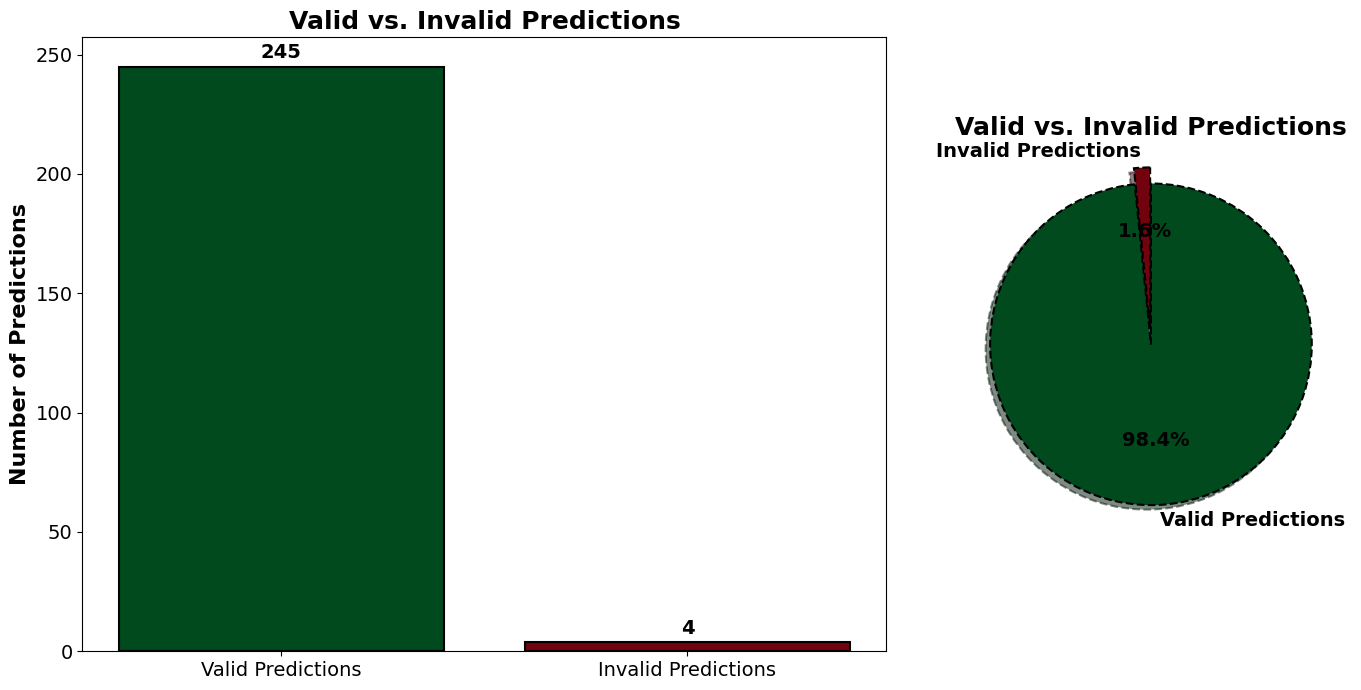

In [ ]:
import torch
import pandas as pd
from scipy import stats  # For calculating the mode



import torch
import pandas as pd
from scipy import stats  # For calculating the mode
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Dataset, Data
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




patient_id =  '015-IL'







# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'),('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}

edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()





class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(HybridSTGCN, self).__init__()

        # Spatial Graph Convolution Layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Temporal Convolution Layers
        self.temporal_conv1 = nn.Conv1d(in_channels=hidden_channels,
                                        out_channels=hidden_channels,
                                        kernel_size=3, padding=1)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)  # Use batch if available, else None

        # Spatial GCN Layers
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))  # x: [num_nodes*batch_size, hidden_channels]

        # Reshape for Temporal Conv
        if batch is not None:
            batch_size = batch.max().item() + 1
            num_nodes = x.size(0) // batch_size
        else:
            batch_size = 1
            num_nodes = x.size(0)

        x = x.view(batch_size, num_nodes, -1)  # [batch_size, num_nodes, hidden_channels]
        x = x.permute(0, 2, 1)  # [batch_size, hidden_channels, num_nodes]

        # Temporal Conv Layer
        x = F.relu(self.temporal_conv1(x))  # [batch_size, hidden_channels, num_nodes]

        # LSTM for capturing temporal patterns
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes, hidden_channels]
        x, _ = self.lstm(x)  # [batch_size, num_nodes, hidden_channels]

        # Pooling over nodes
        x = x.mean(dim=1)  # [batch_size, hidden_channels]

        # Fully Connected Layer
        x = self.fc(x)  # [batch_size, num_classes]
        x = torch.sigmoid(x)  # For binary classification

        return x.squeeze()  # [batch_size]






data_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'



dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]
# Load the saved model
model_save_path = '/content/drive/MyDrive/Iqram Sir/KINZ_Model/hybrid_stgcn_model.pth'






device = torch.device('cpu')

# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set model to evaluation mode












# Function to prepare a single row for prediction
def prepare_single_row_for_prediction(row):
    # Extract node features
    node_features = []
    for joint in joints:
        x = row[f'{joint}_X']
        y = row[f'{joint}_Y']
        z = row[f'{joint}_Z']
        timestamp = row['timeStamps']  # Include timestamp as a feature
        node_features.append([x, y, z, timestamp])

    x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

    # Actual frailty_class (if available)
    y = torch.tensor(row['frailty_class'], dtype=torch.float)

    # Create a Data object
    data = Data(x=x, edge_index=edge_index, y=y)

    return data.to(device)

# Function to predict frailty for all rows of a single patient and show detailed results
def predict_single_patient_frailty(dataframe, patient_id):
    # Filter the dataframe for the specific patient
    patient_data = dataframe[dataframe['patientID'] == patient_id]

    # Create a list to store results
    results = []

    # Store correct and wrong prediction counts
    correct_predictions = 0
    wrong_predictions = 0

    # Iterate over each row corresponding to the patient
    for idx, row in patient_data.iterrows():
        single_sample = prepare_single_row_for_prediction(row)

        # Run the model to make a prediction
        with torch.no_grad():
            output = model(single_sample)

        # Convert the output to binary prediction (frailty or non-frailty based on threshold 0.5)
        predicted_frailty = (output >= 0.5).float().item()

        # Get the actual frailty class
        actual_frailty_class = row['frailty_class']

        # Compare actual frailty with the predicted frailty
        if actual_frailty_class == predicted_frailty:
            prediction_status = "Valid Prediction"
            correct_predictions += 1
        else:
            prediction_status = "Invalid Prediction"
            wrong_predictions += 1

        # Append the results for this row
        results.append({
            'row_number': idx,
            'Ground Truth': actual_frailty_class,
            'Vaid Prediction': predicted_frailty,
            'prediction': prediction_status
        })

    # Convert the results into a pandas DataFrame
    results_df = pd.DataFrame(results)

    # Calculate total number of rows, correct and wrong prediction percentages
    total_rows = len(patient_data)
    right_percentage = (correct_predictions / total_rows) * 100 if total_rows > 0 else 0
    wrong_percentage = (wrong_predictions / total_rows) * 100 if total_rows > 0 else 0

    print(f'Total Rows: {total_rows}')
    print(f'Valid Predictions: {correct_predictions} ({right_percentage:.2f}%)')
    print(f'Invalid Predictions: {wrong_predictions} ({wrong_percentage:.2f}%)')

    # Display rows where the predictions were wrong
    wrong_predictions_df = results_df[results_df['prediction'] == "Invalid Prediction"]
    print(f"\nRows with Invalid predictions:\n{wrong_predictions_df}")

    return results_df, wrong_predictions_df




# Run the prediction for the specified patient and get the results
results_df, wrong_predictions_df = predict_single_patient_frailty(dataframe, patient_id)

# Display the full DataFrame
#results_df

# Optionally, save the results and wrong predictions to CSV files
# results_df.to_csv('frailty_predictions_single_patient.csv', index=False)
# wrong_predictions_df.to_csv('wrong_predictions_single_patient.csv', index=False)



import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

def plot_both_charts(results_df, valid_color='green', invalid_color='red'):
    # Count the number of valid and invalid predictions
    valid_count = len(results_df[results_df['prediction'] == "Valid Prediction"])
    invalid_count = len(results_df[results_df['prediction'] == "Invalid Prediction"])

    # Data
    labels = ['Valid Predictions', 'Invalid Predictions']
    counts = [valid_count, invalid_count]

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [2, 1]})

    # Color maps for gradient effect
    valid_gradient = cm.get_cmap('Greens', 256)
    invalid_gradient = cm.get_cmap('Reds', 256)

    # Generate gradient colors
    valid_gradient_colors = valid_gradient(range(100, 256, 50))
    invalid_gradient_colors = invalid_gradient(range(100, 256, 50))

    # Bar chart with gradient
    bars = ax[0].bar(labels, counts, color=[valid_gradient_colors[-1], invalid_gradient_colors[-1]], edgecolor='black', linewidth=1.5)

    # Remove grid from the bar chart
    ax[0].set_title('Valid vs. Invalid Predictions', fontweight='bold', fontsize=18)
    ax[0].set_ylabel('Number of Predictions', fontweight='bold', fontsize=16)

    # Customize ticks for the bar chart
    ax[0].tick_params(axis='x', labelsize=14)
    ax[0].tick_params(axis='y', labelsize=14)

    # Add value labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax[0].annotate(f'{int(height)}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # Offset label position slightly above the bar
                       textcoords="offset points",
                       ha='center', va='bottom', fontweight='bold', fontsize=14, color='black')

    # Pie chart with 3D effect (wedges)
    wedges, texts, autotexts = ax[1].pie(counts, labels=labels, colors=[valid_gradient_colors[-1], invalid_gradient_colors[-1]],
                                        autopct=lambda p: f'{p:.1f}%', startangle=90, counterclock=False,
                                        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5, 'linestyle': '--'},
                                        shadow=True, explode=[0, 0.1], textprops={'fontsize': 14, 'fontweight': 'bold'})

    # Set title and formatting for pie chart
    ax[1].set_title('Valid vs. Invalid Predictions', fontweight='bold', fontsize=18)

    # Make pie chart labels bold
    for text in autotexts:
        text.set_fontweight('bold')

    # Display the plot
    plt.tight_layout()
    plt.show()


# Call the function with customizable colors
plot_both_charts(results_df, valid_color='#015000', invalid_color='#500000')




In [ ]:
clinic_df = pd.read_csv("/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/ClinicalData80.csv")

In [ ]:
print(clinic_df)

   RecordID  Age     Sex               Ethnicity                       Race  \
0    001-LO   43  Female  Not Hispanic or Latino                      White   
1    002-RJ   77  Female  Not Hispanic or Latino  Black or African American   
2    003-RM   48    Male      Hispanic or Latino                      White   
3    004-MF   54  Female      Hispanic or Latino                      White   
4    005-GP   46    Male      Hispanic or Latino                      White   
..      ...  ...     ...                     ...                        ...   
74   076-AH   60    Male  Not Hispanic or Latino  Black or African American   
75   077-SK   79    Male  Not Hispanic or Latino                      White   
76   078-SM   81    Male  Not Hispanic or Latino                      White   
77   079-KO   78  Female  Not Hispanic or Latino                      White   
78   080-KO   89     NaN                     NaN                        NaN   

    ZipCode SmokingStatus PackyearSmokingHistory Al

In [ ]:
import torch
import pandas as pd
from scipy import stats  # For calculating the mode
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt
import math

# Load the saved model
model_save_path = '/content/drive/MyDrive/Iqram Sir/KINZ_Model/hybrid_stgcn_model.pth'
clinic_df = pd.read_csv("/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/ClinicalData80.csv")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set model to evaluation mode

# Function to prepare a single row for prediction
def prepare_single_row_for_prediction(row):
    # Extract node features
    node_features = []
    for joint in joints:
        x = row[f'{joint}_X']
        y = row[f'{joint}_Y']
        z = row[f'{joint}_Z']
        timestamp = row['timeStamps']  # Include timestamp as a feature
        node_features.append([x, y, z, timestamp])

    x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

    # Actual frailty_class (if available)
    y = torch.tensor(row['frailty_class'], dtype=torch.float)

    # Create a Data object
    data = Data(x=x, edge_index=edge_index, y=y)

    return data.to(device)

# Function to predict frailty for each row of all patients and calculate the mode of predictions
def predict_all_patients_frailty(dataframe):
    # Get the unique patient IDs
    unique_patient_ids = dataframe['patientID'].unique()

    # Create a list to store results
    results = []

    # Iterate over each unique patient ID
    for patient_id in tqdm(unique_patient_ids, desc="Processing patients"):
        # Filter the dataframe for the specific patient
        patient_data = dataframe[dataframe['patientID'] == patient_id]

        # Store the predicted frailty classes and raw model outputs for this patient
        predicted_frailty_classes = []
        raw_model_outputs = []  # To store raw model outputs

        # Iterate over each row corresponding to the patient
        for idx, row in patient_data.iterrows():
            single_sample = prepare_single_row_for_prediction(row)

            # Run the model to make a prediction
            with torch.no_grad():
                output = model(single_sample)

            # Store the raw model output (before thresholding)
            raw_model_outputs.append(output.item())

            # Convert the output to binary prediction (frailty or non-frailty based on threshold 0.5)
            predicted_frailty = (output >= 0.5).float().item()
            predicted_frailty_classes.append(predicted_frailty)

        # Calculate the mode (most frequent predicted frailty class)
        if len(predicted_frailty_classes) > 1:
            mode_result = stats.mode(predicted_frailty_classes, keepdims=True)
            most_frequent_predicted_frailty = mode_result.mode[0]
        else:
            most_frequent_predicted_frailty = predicted_frailty_classes[0]

        # Get the actual frailty class from the dataset (assuming all rows for the patient have the same actual frailty class)
        actual_frailty_class = patient_data['frailty_class'].iloc[0]

        # Calculate valid and invalid predictions
        valid_predictions = sum([1 for pred in predicted_frailty_classes if pred == actual_frailty_class])
        invalid_predictions = len(predicted_frailty_classes) - valid_predictions

        # Calculate percentages
        valid_percentage = (valid_predictions / len(predicted_frailty_classes)) * 100
        invalid_percentage = (invalid_predictions / len(predicted_frailty_classes)) * 100

        # Calculate the average model output
        avg_model_output = sum(raw_model_outputs) / len(raw_model_outputs)

        # Append the results for this patient
        results.append({
            'patientID': patient_id,
            'TotalFFIScore':[],
            'actual_frailty_class': actual_frailty_class,
            'most_frequent_predicted_frailty': most_frequent_predicted_frailty,
            'valid_percentage': valid_percentage,
            'invalid_percentage': invalid_percentage,
            'average_model_output': avg_model_output  # Store the average model output
        })

    # Convert the results into a pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run the prediction for all patients and get the results as a DataFrame
results_df = predict_all_patients_frailty(dataframe)

# Display the DataFrame
#print(results_df)

# Optionally, save the DataFrame to a CSV file
results_df.to_csv('frailty_predictions_with_avg_model_output.csv', index=False)

# Optional: Plot valid vs invalid predictions as a pie chart
def plot_predictions_for_each_subject_square_grid(results_df, valid_color='green', invalid_color='red'):
    # Get the number of subjects
    num_patients = len(results_df)

    # Calculate the number of rows and columns for the square grid
    grid_size = math.ceil(math.sqrt(num_patients))  # To ensure a square-like grid

    # Set up the figure with subplots in a square grid layout
    fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(grid_size * 5, grid_size * 5))

    # Flatten axes for easier iteration (to handle grids with multiple rows/columns)
    axes = axes.flatten()

    # Iterate over each patient and plot the results
    for idx, (i, row) in enumerate(results_df.iterrows()):
        valid_percentage = row['valid_percentage']
        invalid_percentage = row['invalid_percentage']

        # Data for plotting
        labels = ['Valid', 'Invalid']
        counts = [valid_percentage, invalid_percentage]
        colors = [valid_color, invalid_color]

        # Pie chart for each patient
        axes[idx].pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,
                      counterclock=False, textprops={'fontsize': 10, 'fontweight': 'bold'})
        axes[idx].set_title(f"Patient {row['patientID']}", fontsize=14, fontweight='bold')

    # Remove any unused subplots (if any)
    for i in range(num_patients, grid_size * grid_size):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot the results
#plot_predictions_for_each_subject_square_grid(results_df)

results_df



<ipython-input-16-f4ce47f90636>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))
Processing patients: 100%|██████████| 41

,patientID,TotalFFIScore,actual_frailty_class,most_frequent_predicted_frailty,valid_percentage,invalid_percentage,average_model_output
0,007-LI,[],0,0.0,99.492386,0.507614,0.083822
1,014-WF,[],1,1.0,100.000000,0.000000,0.997179
2,020-MM,[],0,0.0,100.000000,0.000000,0.076253
3,005-GP,[],1,1.0,100.000000,0.000000,0.977843
4,001-LO,[],1,1.0,100.000000,0.000000,0.999325
5,002-RJ,[],1,1.0,86.363636,13.636364,0.845408
6,035-LT,[],1,1.0,100.000000,0.000000,0.988700
7,059-ES,[],0,0.0,100.000000,0.000000,0.005054
8,004-MF,[],1,1.0,78.210117,21.789883,0.753837
9,028-DF,[],1,1.0,76.315789,23.684211,0.732749


In [ ]:
clinic_df

In [ ]:
for i in results_df["patientID"]:
  print(i)
  print(clinic_df[clinic_df["RecordID"]==i]["TotalFFIScore"].values[0])


007-LI
0.0
014-WF
2.0
020-MM
0.0
005-GP
1.0
001-LO
1.0
002-RJ
2.0
035-LT
2.0
059-ES
0.0
004-MF
1.0
028-DF
1.0
033-JF
0.0
008-BJ
2.0
038-LB
1.0
025-PS
1.0
037-MA
3.0
017-CS
0.0
009-TB
0.0
019-ER
1.0
048-TT
0.0
RM-003


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import torch
import pandas as pd
from scipy import stats  # For calculating the mode
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt
import math





device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set model to evaluation mode

# Function to prepare a single row for prediction
def prepare_single_row_for_prediction(row):
    # Extract node features
    node_features = []
    for joint in joints:
        x = row[f'{joint}_X']
        y = row[f'{joint}_Y']
        z = row[f'{joint}_Z']
        timestamp = row['timeStamps']  # Include timestamp as a feature
        node_features.append([x, y, z, timestamp])

    x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

    # Actual frailty_class (if available)
    y = torch.tensor(row['frailty_class'], dtype=torch.float)

    # Create a Data object
    data = Data(x=x, edge_index=edge_index, y=y)

    return data.to(device)









# Function to predict frailty for each row of all patients and calculate the mode of predictions
def predict_all_patients_frailty(dataframe, ffiscore_df):
    # Get the unique patient IDs
    unique_patient_ids = dataframe['patientID'].unique()

    # Create a list to store results
    results = []

    # Iterate over each unique patient ID
    for patient_id in tqdm(unique_patient_ids, desc="Processing patients"):
        # Filter the dataframe for the specific patient
        patient_data = dataframe[dataframe['patientID'] == patient_id]

        # Store the predicted frailty classes for this patient
        predicted_frailty_classes = []
        outputs = []

        # Iterate over each row corresponding to the patient
        for idx, row in patient_data.iterrows():
            single_sample = prepare_single_row_for_prediction(row)

            # Run the model to make a prediction
            with torch.no_grad():
                output = model(single_sample)
                outputs.append(output.item())

            # Convert the output to binary prediction (frailty or non-frailty based on threshold 0.5)
            predicted_frailty = (output >= 0.5).float().item()
            predicted_frailty_classes.append(predicted_frailty)

        # Calculate the mode (most frequent predicted frailty class)
        if len(predicted_frailty_classes) > 1:
            mode_result = stats.mode(predicted_frailty_classes, keepdims=True)
            most_frequent_predicted_frailty = mode_result.mode[0]
        else:
            most_frequent_predicted_frailty = predicted_frailty_classes[0]

        # Get the actual frailty class from the dataset (assuming all rows for the patient have the same actual frailty class)
        actual_frailty_class = patient_data['frailty_class'].iloc[0]

        # Get the "TotalFFIScore" from ffiscore_df for the corresponding patientID
        total_ffi_score = ffiscore_df.loc[ffiscore_df['patientID'] == patient_id, 'TotalFFIScore'].values[0]

        # Calculate valid and invalid predictions
        valid_predictions = sum([1 for pred in predicted_frailty_classes if pred == actual_frailty_class])
        invalid_predictions = len(predicted_frailty_classes) - valid_predictions

        # Calculate percentages
        valid_percentage = (valid_predictions / len(predicted_frailty_classes)) * 100
        invalid_percentage = (invalid_predictions / len(predicted_frailty_classes)) * 100

        # Calculate the average output of the model for this patient
        avg_output = sum(outputs) / len(outputs)

        # Append the results for this patient
        results.append({
            'patientID': patient_id,
            'TotalFFIScore': total_ffi_score,  # Added column
            'actual_frailty_class': actual_frailty_class,
            'valid_percentage': valid_percentage,
            'invalid_percentage': invalid_percentage,
            'average_model_output': avg_output  # Average model output for the patient
        })

    # Convert the results into a pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df





ffiscore_df = pd.read_csv("/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/ClinicalData80.csv")


# Run the prediction for all patients and get the results as a DataFrame
results_df = predict_all_patients_frailty(dataframe, ffiscore_df)

# Display the DataFrame
#print(results_df)

# Optionally, save the DataFrame to a CSV file
#results_df.to_csv('frailty_predictions_with_ffi_and_percentages.csv', index=False)

results_df


Processing patients:   0%|          | 0/41 [00:00<?, ?it/s]

Total Rows: 394
Valid Predictions: 392 (99.49%)
Invalid Predictions: 2 (0.51%)

Rows with Invalid predictions:
     row_number  Ground Truth  Vaid Prediction          prediction
30         2601             0              1.0  Invalid Prediction
270       30854             0              1.0  Invalid Prediction
Total Rows: 626
Valid Predictions: 626 (100.00%)
Invalid Predictions: 0 (0.00%)

Rows with Invalid predictions:
Empty DataFrame
Columns: [row_number, Ground Truth, Vaid Prediction, prediction]
Index: []
Total Rows: 353
Valid Predictions: 353 (100.00%)
Invalid Predictions: 0 (0.00%)

Rows with Invalid predictions:
Empty DataFrame
Columns: [row_number, Ground Truth, Vaid Prediction, prediction]
Index: []
Total Rows: 172
Valid Predictions: 172 (100.00%)
Invalid Predictions: 0 (0.00%)

Rows with Invalid predictions:
Empty DataFrame
Columns: [row_number, Ground Truth, Vaid Prediction, prediction]
Index: []
Total Rows: 959
Valid Predictions: 959 (100.00%)
Invalid Predictions: 0 (0.00%)

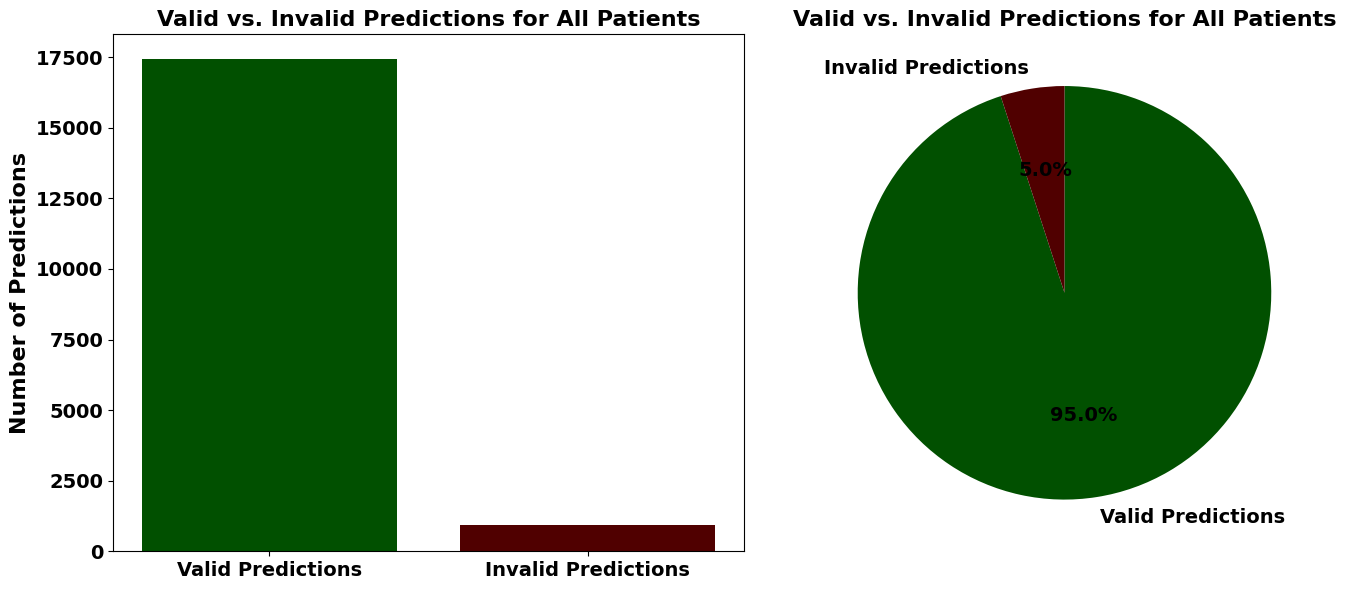

In [ ]:
# Function to predict frailty for all patients and aggregate the results
def predict_all_patients_frailty(dataframe):
    # Get a list of unique patient IDs
    patient_ids = dataframe['patientID'].unique()

    # Initialize counters for valid and invalid predictions
    total_valid_predictions = 0
    total_invalid_predictions = 0
    total_rows = 0

    # Create a DataFrame to store all results
    all_results = []

    # Iterate over all patient IDs
    for patient_id in tqdm(patient_ids, desc="Processing patients"):
        # Run the prediction for each patient
        results_df, _ = predict_single_patient_frailty(dataframe, patient_id)

        # Aggregate the results for the patient
        valid_predictions = len(results_df[results_df['prediction'] == "Valid Prediction"])
        invalid_predictions = len(results_df[results_df['prediction'] == "Invalid Prediction"])
        total_rows += len(results_df)

        # Update overall counts
        total_valid_predictions += valid_predictions
        total_invalid_predictions += invalid_predictions

        # Store the results for all patients
        all_results.append(results_df)

    # Calculate the percentages
    valid_percentage = (total_valid_predictions / total_rows) * 100 if total_rows > 0 else 0
    invalid_percentage = (total_invalid_predictions / total_rows) * 100 if total_rows > 0 else 0

    print(f'Total Rows: {total_rows}')
    print(f'Valid Predictions: {total_valid_predictions} ({valid_percentage:.2f}%)')
    print(f'Invalid Predictions: {total_invalid_predictions} ({invalid_percentage:.2f}%)')

    # Return the overall results
    return total_valid_predictions, total_invalid_predictions


# Function to predict frailty for all patients and aggregate the results
def predict_all_patients_frailty_sep(dataframe):
    # Get a list of unique patient IDs
    patient_ids = dataframe['patientID'].unique()

    # Create a dictionary to store valid and invalid predictions for each patient
    patient_results = {}

    # Iterate over all patient IDs
    for patient_id in tqdm(patient_ids, desc="Processing patients"):
        # Run the prediction for each patient
        results_df, _ = predict_single_patient_frailty(dataframe, patient_id)

        # Count valid and invalid predictions
        valid_predictions = len(results_df[results_df['prediction'] == "Valid Prediction"])
        invalid_predictions = len(results_df[results_df['prediction'] == "Invalid Prediction"])

        # Store the results for the current patient
        patient_results[patient_id] = {
            'valid': valid_predictions,
            'invalid': invalid_predictions
        }

    return patient_results




# Function to plot the aggregated predictions for all patients
def plot_aggregated_predictions(total_valid_predictions, total_invalid_predictions, valid_color='green', invalid_color='red'):
    # Data
    labels = ['Valid Predictions', 'Invalid Predictions']
    counts = [total_valid_predictions, total_invalid_predictions]
    colors = [valid_color, invalid_color]

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart
    ax[0].bar(labels, counts, color=colors)
    ax[0].set_title('Valid vs. Invalid Predictions for All Patients', fontweight='bold', fontsize=16)
    ax[0].set_ylabel('Number of Predictions', fontweight='bold', fontsize=16)

    # Customize ticks for the bar chart
    ax[0].tick_params(axis='x', labelsize=14)
    ax[0].tick_params(axis='y', labelsize=14)

    # Make the ticks bold
    for tick in ax[0].get_xticklabels() + ax[0].get_yticklabels():
        tick.set_fontweight('bold')

    # Pie chart
    ax[1].pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,
              counterclock=False, textprops={'fontsize': 14, 'fontweight': 'bold'})
    ax[1].set_title('Valid vs. Invalid Predictions for All Patients', fontweight='bold', fontsize=16)

    # Display the plot
    plt.tight_layout()
    plt.show()


import math
import matplotlib.pyplot as plt

# Function to plot valid and invalid predictions for each subject in a square grid
def plot_predictions_for_each_subject_square_grid(patient_results, valid_color='green', invalid_color='red'):
    # Get the number of subjects
    num_patients = len(patient_results)

    # Calculate the number of rows and columns for the square grid
    grid_size = math.ceil(math.sqrt(num_patients))  # To ensure a square-like grid

    # Set up the figure with subplots in a square grid layout
    fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(grid_size * 5, grid_size * 5))

    # Flatten axes for easier iteration (to handle grids with multiple rows/columns)
    axes = axes.flatten()

    # Iterate over each patient and plot the results
    for idx, (patient_id, results) in enumerate(patient_results.items()):
        valid_count = results['valid']
        invalid_count = results['invalid']

        # Data for plotting
        labels = ['Valid', 'Invalid']
        counts = [valid_count, invalid_count]
        colors = [valid_color, invalid_color]

        # Bar chart for each patient
        axes[idx].bar(labels, counts, color=colors)
        axes[idx].set_title(f'{patient_id}: Valid vs. Invalid', fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Number of Predictions', fontsize=12)
        axes[idx].tick_params(axis='x', labelsize=10)
        axes[idx].tick_params(axis='y', labelsize=10)

    # Remove any unused subplots (if any)
    for i in range(num_patients, grid_size * grid_size):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()


import math
import matplotlib.pyplot as plt

# Function to plot valid and invalid predictions for each subject in a square grid
def plot_predictions_for_each_subject_square_grid(patient_results, valid_color='green', invalid_color='red'):
    # Get the number of subjects
    num_patients = len(patient_results)

    # Calculate the number of rows and columns for the square grid
    grid_size = math.ceil(math.sqrt(num_patients))  # To ensure a square-like grid

    # Set up the figure with subplots in a square grid layout
    fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(grid_size * 5, grid_size * 5))

    # Flatten axes for easier iteration (to handle grids with multiple rows/columns)
    axes = axes.flatten()

    # Iterate over each patient and plot the results
    for idx, (patient_id, results) in enumerate(patient_results.items()):
        valid_count = results['valid']
        invalid_count = results['invalid']

        # Data for plotting
        labels = ['Valid', 'Invalid']
        counts = [valid_count, invalid_count]
        colors = [valid_color, invalid_color]

        # Bar chart for each patient
        axes[idx].bar(labels, counts, color=colors)
        axes[idx].set_title(f'{patient_id}: Valid vs. Invalid', fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Number of Predictions', fontsize=12)
        axes[idx].tick_params(axis='x', labelsize=10)
        axes[idx].tick_params(axis='y', labelsize=10)

    # Remove any unused subplots (if any)
    for i in range(num_patients, grid_size * grid_size):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()





# Run the prediction for all patients and get the aggregated results
total_valid_predictions, total_invalid_predictions = predict_all_patients_frailty(dataframe)



# Plot the aggregated predictions
plot_aggregated_predictions(total_valid_predictions, total_invalid_predictions, valid_color='#015000', invalid_color='#500000')






In [ ]:
# Example patient results data (replace this with actual results)
# patient_results = predict_all_patients_frailty(dataframe)

# Plot each subject's valid and invalid predictions in a square grid
plot_predictions_for_each_subject_square_grid(patient_results, valid_color='#015000', invalid_color='#500000')





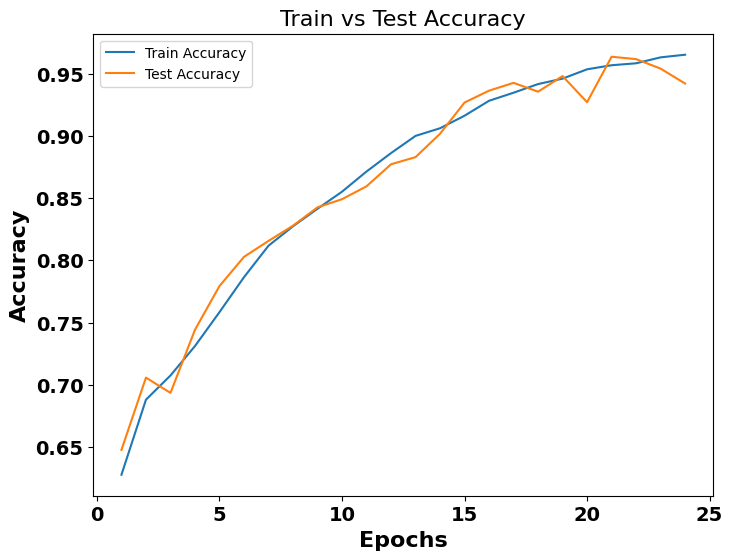

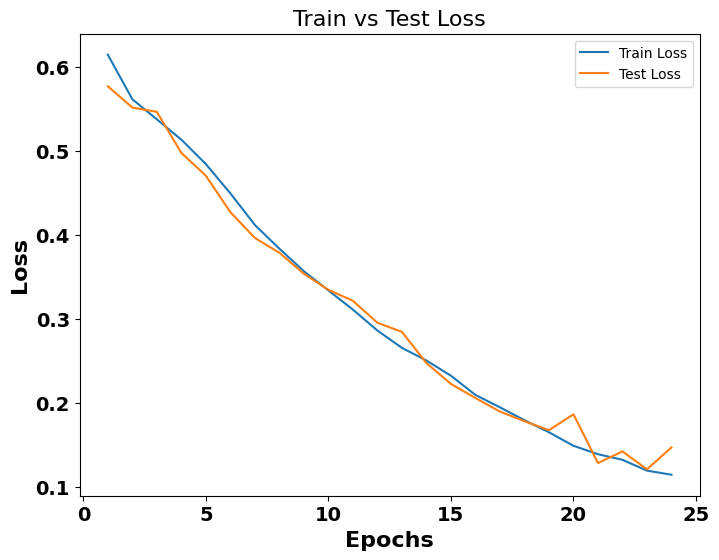

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, len(train_accuracies) + 1)

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Accuracy', fontsize=16)
plt.legend()
plt.show()

# Plot loss curves
plt.figure(figsize=(8, 6))  # Ensure the same size as the accuracy plot
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Loss', fontsize=16)
plt.legend()
plt.show()


# MOdel PLOTING

In [ ]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=756816083fc3e242c6e669f8a4dfc2e12cf347d2a9b9264627688954d33296ec
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Dataset
import pandas as pd
from torchviz import make_dot

# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}

edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()

# Custom Dataset Class
class SkeletonDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file
        self.num_nodes = len(joints)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract node features and include timestamp
        node_features = []
        for joint in joints:
            x = row[f'{joint}_X']
            y = row[f'{joint}_Y']
            z = row[f'{joint}_Z']
            timestamp = row['timeStamps']  # Include timestamp as a feature
            node_features.append([x, y, z, timestamp])

        x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

        # Label
        y = torch.tensor(row['frailty_class'], dtype=torch.float)

        # Create data object
        data = Data(x=x, edge_index=edge_index, y=y)

        return data

# Define the HybridSTGCN Model
class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(HybridSTGCN, self).__init__()

        # Spatial Graph Convolution Layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Temporal Convolution Layers
        self.temporal_conv1 = nn.Conv1d(in_channels=hidden_channels,
                                        out_channels=hidden_channels,
                                        kernel_size=3, padding=1)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)  # Use batch if available, else None

        # Spatial GCN Layers
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))  # x: [num_nodes*batch_size, hidden_channels]

        # Reshape for Temporal Conv
        if batch is not None:
            batch_size = batch.max().item() + 1
            num_nodes = x.size(0) // batch_size
        else:
            batch_size = 1
            num_nodes = x.size(0)

        x = x.view(batch_size, num_nodes, -1)  # [batch_size, num_nodes, hidden_channels]
        x = x.permute(0, 2, 1)  # [batch_size, hidden_channels, num_nodes]

        # Temporal Conv Layer
        x = F.relu(self.temporal_conv1(x))  # [batch_size, hidden_channels, num_nodes]

        # LSTM for capturing temporal patterns
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes, hidden_channels]
        x, _ = self.lstm(x)  # [batch_size, num_nodes, hidden_channels]

        # Pooling over nodes
        x = x.mean(dim=1)  # [batch_size, hidden_channels]

        # Fully Connected Layer
        x = self.fc(x)  # [batch_size, num_classes]
        x = torch.sigmoid(x)  # For binary classification

        return x.squeeze()  # [batch_size]

# Load the dataset
data_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'
dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]

# Create Dataset
dataset = SkeletonDataset(dataframe)

# Load the saved model with weights_only=True (recommended)
model_save_path = '/content/drive/MyDrive/Iqram Sir/KINZ_Model/hybrid_stgcn_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
model.load_state_dict(torch.load(model_save_path, weights_only=True))  # Set weights_only=True
model.eval()

# Get a sample from the dataset
data_sample = dataset[0].to(device)

# Forward pass through the model
output = model(data_sample)

# Plot the computation graph using torchviz with high resolution and colors
graph = make_dot(output, params=dict(list(model.named_parameters())))

# Update graph attributes for DPI and node text
graph.graph_attr.update(dpi='1000')  # High resolution
graph.node_attr.update(fontname='Helvetica', fontsize='16', style='bold')  # Bold text for nodes

# Manually color nodes based on the layer type
for node in graph.body:
    if 'gcn1' in node or 'gcn2' in node:
        node = node.replace(']', ' color=lightblue, style=filled]')  # GCNConv -> Blue
    elif 'lstm' in node:
        node = node.replace(']', ' color=lightgreen, style=filled]')  # LSTM -> Green
    elif 'temporal_conv1' in node:
        node = node.replace(']', ' color=yellow, style=filled]')  # TemporalConv -> Yellow
    elif 'fc' in node:
        node = node.replace(']', ' color=orange, style=filled]')  # Fully Connected -> Orange

# Render the graph with color formatting
graph.render("hybrid_stgcn_colored_graph", format="png")


'hybrid_stgcn_colored_graph.png'

# GRAD CAM

In [ ]:
import torch
import pandas as pd
from scipy import stats  # For calculating the mode



import torch
import pandas as pd
from scipy import stats  # For calculating the mode
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Dataset, Data
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np





# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'),('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}




edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()


# Custom Dataset Class
class SkeletonDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file
        self.num_nodes = len(joints)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract node features and include timestamp
        node_features = []
        for joint in joints:
            x = row[f'{joint}_X']
            y = row[f'{joint}_Y']
            z = row[f'{joint}_Z']
            timestamp = row['timeStamps']  # Include timestamp as a feature
            node_features.append([x, y, z, timestamp])

        x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

        # Label
        y = torch.tensor(row['frailty_class'], dtype=torch.float)

        # Create data object
        data = Data(x=x, edge_index=edge_index, y=y)

        return data







class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(HybridSTGCN, self).__init__()

        # Spatial Graph Convolution Layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Temporal Convolution Layers
        self.temporal_conv1 = nn.Conv1d(in_channels=hidden_channels,
                                        out_channels=hidden_channels,
                                        kernel_size=3, padding=1)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)  # Use batch if available, else None

        # Spatial GCN Layers
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))  # x: [num_nodes*batch_size, hidden_channels]

        # Reshape for Temporal Conv
        if batch is not None:
            batch_size = batch.max().item() + 1
            num_nodes = x.size(0) // batch_size
        else:
            batch_size = 1
            num_nodes = x.size(0)

        x = x.view(batch_size, num_nodes, -1)  # [batch_size, num_nodes, hidden_channels]
        x = x.permute(0, 2, 1)  # [batch_size, hidden_channels, num_nodes]

        # Temporal Conv Layer
        x = F.relu(self.temporal_conv1(x))  # [batch_size, hidden_channels, num_nodes]

        # LSTM for capturing temporal patterns
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes, hidden_channels]
        x, _ = self.lstm(x)  # [batch_size, num_nodes, hidden_channels]

        # Pooling over nodes
        x = x.mean(dim=1)  # [batch_size, hidden_channels]

        # Fully Connected Layer
        x = self.fc(x)  # [batch_size, num_classes]
        x = torch.sigmoid(x)  # For binary classification

        return x.squeeze()  # [batch_size]






data_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'



dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]
# Load the saved model
model_save_path = '/content/drive/MyDrive/Iqram Sir/KINZ_Model/hybrid_stgcn_model.pth'






device = torch.device('cpu')

# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set model to evaluation mode


<ipython-input-1-c308ebe219ed>:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


HybridSTGCN(
  (gcn1): GCNConv(4, 128)
  (gcn2): GCNConv(128, 128)
  (temporal_conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
import torch
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

class GradCAM_GNN:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Register forward and backward hooks on the target layer
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate_cam(self, data):
        self.model.eval()

        # Forward pass on the single sample
        output = self.model(data)

        # Backward pass to compute gradients
        self.model.zero_grad()
        output.backward()

        # Generate the CAM by multiplying the activations with the gradients
        cam = self.gradients * self.activations  # Shape: [hidden_channels, num_nodes]

        # Average across the channels (feature maps) to get the final CAM per node
        node_cam = cam.mean(dim=0)  # Shape: [num_nodes]

        # Normalize the node CAM to [0, 1]
        node_cam = node_cam - node_cam.min()
        node_cam = node_cam / node_cam.max()

        # Calculate edge importance by averaging the CAM values of the connected nodes
        edge_index = data.edge_index.cpu().numpy()
        edge_cam = []
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[:, i]
            edge_imp = (node_cam[src] + node_cam[dst]) / 2.0  # Averaging node CAMs for the edge
            edge_cam.append(edge_imp.item())

        edge_cam = np.array(edge_cam)

        return node_cam.detach().cpu().numpy(), edge_cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# Visualization function for a single sample in 3D using Plotly with color scale
def visualize_human_skeleton_3d_plotly(cam, data, title="3D Grad-CAM Visualization"):
    node_cam, edge_cam = cam
    node_positions = data.x[:, :3].cpu().numpy()  # Assume first 3 columns are X, Y, Z

    # Create a scatter plot for the joints
    scatter = go.Scatter3d(
        x=node_positions[:, 0],
        y=node_positions[:, 1],
        z=node_positions[:, 2],
        mode='markers+text',
        text=[f'{i}' for i in range(node_positions.shape[0])],
        marker=dict(
            size=8,
            color=node_cam,
            colorscale='Viridis',
            colorbar=dict(title="Node Grad-CAM Value", x=0.9),  # Add color bar for node Grad-CAM values
            opacity=0.8
        )
    )

    # Create lines for the edges (bones)
    edge_index = data.edge_index.cpu().numpy()
    edge_x = []
    edge_y = []
    edge_z = []
    edge_colors = []
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        edge_x.extend([node_positions[src, 0], node_positions[dst, 0], None])
        edge_y.extend([node_positions[src, 1], node_positions[dst, 1], None])
        edge_z.extend([node_positions[src, 2], node_positions[dst, 2], None])
        edge_colors.extend([edge_cam[i], edge_cam[i], edge_cam[i]])  # Use the edge importance for coloring

    # Ensure that there are no None values in edge_colors
    edge_colors = np.array(edge_colors)
    edge_colors = np.nan_to_num(edge_colors, nan=0.0)  # Replace None or NaN with 0.0

    lines = go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode='lines',
        line=dict(
            color=edge_colors,
            colorscale='Viridis',
            width=4,
            colorbar=dict(title="Edge Grad-CAM Value", x=1.05)  # Position the edge color bar separately
        ),
        hoverinfo='none'
    )

    # Combine the scatter plot and lines into a single figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
    fig.add_trace(scatter)
    fig.add_trace(lines)

    # Set the layout for better visualization, remove background and ticks
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', showgrid=False, backgroundcolor="white", showticklabels=False),
            yaxis=dict(title='Y', showgrid=False, backgroundcolor="white", showticklabels=False),
            zaxis=dict(title='Z', showgrid=False, backgroundcolor="white", showticklabels=False),
            aspectmode='cube',
            bgcolor="white"  # Set overall scene background color to white
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        paper_bgcolor="white",  # Set the background color of the figure
        plot_bgcolor="white",  # Set the background color of the plot area
        title=title,
        showlegend=False
    )

    fig.show()




### GRAD CAM PLOT

In [ ]:
# Specify the patient ID you want to visualize
patient_id = '047-MW'  # Replace with actual patient ID
# Filter the dataset for the specific patient
patient_data = dataframe[dataframe['patientID'] == patient_id]  # Assuming dataframe has 'patientID' column
patient_dataset = SkeletonDataset(patient_data)

# Create a DataLoader for the specific patient
patient_loader = DataLoader(patient_dataset, batch_size=1, shuffle=False)  # Batch size 1 to load one sample at a time

target_layer = model.gcn2 # Example target layer
grad_cam = GradCAM_GNN(model, target_layer)

# Specify which data points you want to plot
points_to_plot = [80]  # Change this list to include the desired data points

# Loop through the DataLoader and select the specified data points
for i, single_sample in enumerate(patient_loader, 1):  # Start index from 1
    if i in points_to_plot:
        print(f"Visualizing {i}-th data point for patient {patient_id}... and Layer {target_layer}")

        single_sample = single_sample.to(device)

        # Generate and visualize the CAM for this single patient sample
        cam = grad_cam.generate_cam(single_sample)
        visualize_human_skeleton_3d_plotly(cam, single_sample, title=f"Grad-CAM for Patient {patient_id}, Data Point {i}")

# Remove the hooks to clean up
grad_cam.remove_hooks()

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Visualizing 80-th data point for patient 047-MW... and Layer GCNConv(128, 128)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [ ]:
import torch
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from tqdm import tqdm

# Function to visualize Grad-CAM with animation for a patient
def generate_gradcam_animation(patient_id, dataframe):
    patient_data = dataframe[dataframe['patientID'] == patient_id]
    patient_dataset = SkeletonDataset(patient_data)

    # Create a DataLoader for the specific patient
    patient_loader = DataLoader(patient_dataset, batch_size=1, shuffle=False)

    # Initialize Grad-CAM for a specific layer
    target_layer = model.gcn2  # Example target layer
    grad_cam = GradCAM_GNN(model, target_layer)

    frames = []  # Store frames for animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame: ",
            "visible": True,
            "xanchor": "right"
        },
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }

    # Loop through the DataLoader and generate visualizations for each data point
    first_frame_data = None
    for i, single_sample in enumerate(tqdm(patient_loader, desc="Processing frames"), 1):
        single_sample = single_sample.to(device)

        # Generate the CAM for the current sample
        cam = grad_cam.generate_cam(single_sample)

        # Prepare the plot data (scatter and lines)
        node_cam, edge_cam = cam
        node_positions = single_sample.x[:, :3].cpu().numpy()  # Assume first 3 columns are X, Y, Z

        scatter = go.Scatter3d(
            x=node_positions[:, 0],
            y=node_positions[:, 1],
            z=node_positions[:, 2],
            mode='markers+text',
            text=[f'{i}' for i in range(node_positions.shape[0])],
            marker=dict(
                size=8,
                color=node_cam,
                colorscale='Viridis',
                colorbar=dict(title="Node Grad-CAM Value", x=0.9),
                opacity=0.8
            )
        )

        # Create lines for the edges (bones)
        edge_index = single_sample.edge_index.cpu().numpy()
        edge_x, edge_y, edge_z, edge_colors = [], [], [], []
        for j in range(edge_index.shape[1]):
            src, dst = edge_index[:, j]
            edge_x.extend([node_positions[src, 0], node_positions[dst, 0], None])
            edge_y.extend([node_positions[src, 1], node_positions[dst, 1], None])
            edge_z.extend([node_positions[src, 2], node_positions[dst, 2], None])
            edge_colors.extend([edge_cam[j], edge_cam[j], edge_cam[j]])

        # Replace None/NaN with 0.0
        edge_colors = np.array(edge_colors)
        edge_colors = np.nan_to_num(edge_colors, nan=0.0)

        lines = go.Scatter3d(
            x=edge_x, y=edge_y, z=edge_z, mode='lines',
            line=dict(color=edge_colors, colorscale='Viridis', width=4),
            hoverinfo='none'
        )

        if first_frame_data is None:
            first_frame_data = [scatter, lines]  # Capture the first frame

        # Create the frame and add it to the animation
        frames.append(go.Frame(data=[scatter, lines], name=str(i)))

        # Create slider step for each frame
        slider_step = {
            "args": [
                [str(i)], {"frame": {"duration": 500, "redraw": True}, "mode": "immediate", "transition": {"duration": 300}}
            ],
            "label": str(i),
            "method": "animate"
        }
        sliders_dict["steps"].append(slider_step)

    # Define the layout for the figure
    layout = go.Layout(
        scene=dict(
            aspectmode='cube',
            xaxis=dict(range=[-1, 1], autorange=False, title="X"),
            yaxis=dict(range=[-1, 1], autorange=False, title="Y"),
            zaxis=dict(range=[-1, 1], autorange=False, title="Z")
        ),
        title=f"Grad-CAM for Patient {patient_id}",
        updatemenus=[{
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True, "transition": {"duration": 300, "easing": "quadratic-in-out"}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }],
        sliders=[sliders_dict]
    )

    # Create the figure with the first frame and frames for animation
    fig = go.Figure(
        data=first_frame_data,  # Initialize with the first frame
        layout=layout,
        frames=frames  # Add frames for animation
    )

    # Show the figure
    fig.show()

# Example usage
patient_id = '047-MW'  # Replace with actual patient ID
generate_gradcam_animation(patient_id, dataframe)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install -U kaleido
!pip uninstall -y kaleido
!pip install kaleido

In [ ]:
import torch
import os
import imageio
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from tqdm import tqdm

# Define folder to store images
image_folder = 'gradcam_frames'
os.makedirs(image_folder, exist_ok=True)

# Function to save Grad-CAM visualizations for each data point
def save_gradcam_plot_as_image(cam, data, title, file_name):
    node_cam, edge_cam = cam
    node_positions = data.x[:, :3].cpu().numpy()  # Assume first 3 columns are X, Y, Z

    # Create a scatter plot for the joints
    scatter = go.Scatter3d(
        x=node_positions[:, 0],
        y=node_positions[:, 1],
        z=node_positions[:, 2],
        mode='markers+text',
        text=[f'{i}' for i in range(node_positions.shape[0])],
        marker=dict(
            size=8,
            color=node_cam,
            colorscale='Viridis',
            colorbar=dict(title="Node Grad-CAM Value", x=0.9),
            opacity=0.8
        )
    )

    # Create lines for the edges (bones)
    edge_index = data.edge_index.cpu().numpy()
    edge_x, edge_y, edge_z, edge_colors = [], [], [], []
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        edge_x.extend([node_positions[src, 0], node_positions[dst, 0], None])
        edge_y.extend([node_positions[src, 1], node_positions[dst, 1], None])
        edge_z.extend([node_positions[src, 2], node_positions[dst, 2], None])
        edge_colors.extend([edge_cam[i], edge_cam[i], edge_cam[i]])

    # Replace None/NaN with 0.0
    edge_colors = np.array(edge_colors)
    edge_colors = np.nan_to_num(edge_colors, nan=0.0)

    lines = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z, mode='lines',
        line=dict(color=edge_colors, colorscale='Viridis', width=4),
        hoverinfo='none'
    )

    # Combine the scatter plot and lines into a single figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
    fig.add_trace(scatter)
    fig.add_trace(lines)

    # Set layout and save the plot as an image
    fig.update_layout(scene=dict(aspectmode='cube'), margin=dict(l=0, r=0, b=0, t=0), title=title, showlegend=False)
    fig.write_image(file_name)

# Create a video from the saved frames
def create_video_from_frames(image_folder, output_video):
    images = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".png")])
    video_writer = imageio.get_writer(output_video, fps=2)  # Adjust FPS as needed
    for image_file in images:
        img = imageio.imread(image_file)
        video_writer.append_data(img)
    video_writer.close()





# Function to save Grad-CAM visualizations for each data point with adjusted orientation
def save_gradcam_plot_as_image(cam, data, title, file_name):
    node_cam, edge_cam = cam
    node_positions = data.x[:, :3].cpu().numpy()  # Assume first 3 columns are X, Y, Z

    # Create a scatter plot for the joints
    scatter = go.Scatter3d(
        x=node_positions[:, 0],
        y=node_positions[:, 1],
        z=node_positions[:, 2],
        mode='markers+text',
        text=[f'{i}' for i in range(node_positions.shape[0])],
        marker=dict(
            size=8,
            color=node_cam,
            colorscale='Viridis',
            colorbar=dict(title="Node Grad-CAM Value", x=0.9),
            opacity=0.8
        )
    )

    # Create lines for the edges (bones)
    edge_index = data.edge_index.cpu().numpy()
    edge_x, edge_y, edge_z, edge_colors = [], [], [], []
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        edge_x.extend([node_positions[src, 0], node_positions[dst, 0], None])
        edge_y.extend([node_positions[src, 1], node_positions[dst, 1], None])
        edge_z.extend([node_positions[src, 2], node_positions[dst, 2], None])
        edge_colors.extend([edge_cam[i], edge_cam[i], edge_cam[i]])

    # Replace None/NaN with 0.0
    edge_colors = np.array(edge_colors)
    edge_colors = np.nan_to_num(edge_colors, nan=0.0)

    lines = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z, mode='lines',
        line=dict(color=edge_colors, colorscale='Viridis', width=4),
        hoverinfo='none'
    )

    # Define the camera orientation (adjust these values to get the desired view)
    camera = dict(
        eye=dict(x=5, y=2, z=10)  # Adjust 'x', 'y', and 'z' to set the viewing angle
    )

    # Combine the scatter plot and lines into a single figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
    fig.add_trace(scatter)
    fig.add_trace(lines)

    # Set layout and save the plot as an image with a fixed camera orientation
    fig.update_layout(scene=dict(aspectmode='cube', camera=camera),
                      margin=dict(l=0, r=0, b=0, t=0), title=title, showlegend=False)
    fig.write_image(file_name)

# Example usage of the function remains unchanged
patient_id = '047-MW'  # Replace with actual patient ID
video_output = "gradcam_patient_047-MW.mp4"

generate_gradcam_video(patient_id, dataframe, video_output=video_output)



Generating Grad-CAM for patient 047-MW...


Processing frames: 100%|██████████| 150/150 [06:35<00:00,  2.64s/it]
<ipython-input-5-31e2413251df>:67: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



Creating video for patient 047-MW...
Video saved to gradcam_patient_047-MW.mp4


In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import torch

# Function to visualize a single Grad-CAM plot with adjustable camera orientation
def test_gradcam_camera_orientation(cam, data, title="Grad-CAM Test", camera_eye=dict(x=1.5, y=1.5, z=1.5)):
    node_cam, edge_cam = cam
    node_positions = data.x[:, :3].cpu().numpy()  # Assume first 3 columns are X, Y, Z

    # Create a scatter plot for the joints
    scatter = go.Scatter3d(
        x=node_positions[:, 0],
        y=node_positions[:, 1],
        z=node_positions[:, 2],
        mode='markers+text',
        text=[f'{i}' for i in range(node_positions.shape[0])],
        marker=dict(
            size=8,
            color=node_cam,
            colorscale='Viridis',
            colorbar=dict(title="Node Grad-CAM Value", x=0.9),
            opacity=0.8
        )
    )

    # Create lines for the edges (bones)
    edge_index = data.edge_index.cpu().numpy()
    edge_x, edge_y, edge_z, edge_colors = [], [], [], []
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        edge_x.extend([node_positions[src, 0], node_positions[dst, 0], None])
        edge_y.extend([node_positions[src, 1], node_positions[dst, 1], None])
        edge_z.extend([node_positions[src, 2], node_positions[dst, 2], None])
        edge_colors.extend([edge_cam[i], edge_cam[i], edge_cam[i]])

    # Replace None/NaN with 0.0
    edge_colors = np.array(edge_colors)
    edge_colors = np.nan_to_num(edge_colors, nan=0.0)

    lines = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z, mode='lines',
        line=dict(color=edge_colors, colorscale='Viridis', width=4),
        hoverinfo='none'
    )

    # Combine the scatter plot and lines into a single figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
    fig.add_trace(scatter)
    fig.add_trace(lines)

    # Set layout with the adjustable camera
    fig.update_layout(scene=dict(aspectmode='cube', camera=dict(eye=camera_eye)),
                      margin=dict(l=0, r=0, b=0, t=0), title=title, showlegend=False)

    # Show the plot interactively
    fig.show()

# Example usage for a single data point (adjust camera_eye to test)
patient_id = '047-MW'  # Replace with actual patient ID
points_to_plot = [50]  # Test on a single data point

# Fetch patient data (assuming your dataframe is loaded)
patient_data = dataframe[dataframe['patientID'] == patient_id]
patient_dataset = SkeletonDataset(patient_data)
single_sample = patient_dataset[points_to_plot[0]]  # Test on a specific data point
single_sample = single_sample.to(device)

# Initialize Grad-CAM for the target layer
target_layer = model.gcn2  # Example target layer
grad_cam = GradCAM_GNN(model, target_layer)

# Generate Grad-CAM for the selected data point
cam = grad_cam.generate_cam(single_sample)

# Test with different camera orientations (adjust the values of x, y, z)
camera_eye_test = dict(x=0.5, y=2, z=-8)  # Adjust the values to change the orientation

# Visualize the plot with the adjusted camera orientation
test_gradcam_camera_orientation(cam, single_sample, title="Test Grad-CAM Camera Orientation", camera_eye=camera_eye_test)

# Remove the hooks to clean up
grad_cam.remove_hooks()


In [ ]:
# Specify the patient ID you want to visualize
patient_id = '037-MA'  # Replace with actual patient ID
# Filter the dataset for the specific patient
patient_data = dataframe[dataframe['patientID'] == patient_id]  # Assuming dataframe has 'patientID' column
patient_dataset = SkeletonDataset(patient_data)

# Create a DataLoader for the specific patient
patient_loader = DataLoader(patient_dataset, batch_size=1, shuffle=False)  # Batch size 1 to load one sample at a time

target_layer = model.gcn2  # Example target layer
grad_cam = GradCAM_GNN(model, target_layer)

# Specify which data points you want to plot
points_to_plot = [80]  # Change this list to include the desired data points

# Loop through the DataLoader and select the specified data points
for i, single_sample in enumerate(patient_loader, 1):  # Start index from 1
    if i in points_to_plot:
        print(f"Visualizing {i}-th data point for patient {patient_id}... and Layer {target_layer}")

        single_sample = single_sample.to(device)

        # Generate and visualize the CAM for this single patient sample
        cam = grad_cam.generate_cam(single_sample)
        visualize_human_skeleton_3d_plotly(cam, single_sample, title=f"Grad-CAM for Patient {patient_id}, Data Point {i}")

# Remove the hooks to clean up
grad_cam.remove_hooks()

Visualizing 80-th data point for patient 037-MA... and Layer GCNConv(128, 128)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

